In [16]:
import os
import cv2
import numpy as np
import joblib
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog

In [65]:
DATA_DIR_TRAIN = 'data/train'
DATA_DIR_TEST = 'data/test'
DATA_DIR_VAL = 'data/val'

TARGET_CLASS = 'car'
NEG_CLASS = 'background'
MODEL_DIR = 'models/'

In [ ]:
# based on the standard configuration established by the original Dalal & Triggs paper (2005) for human detection.
HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (8, 8), # divides image into a grid of squares, calculate the gradient for every pixel and pools them into a single histogram
    'cells_per_block': (2, 2), # performs normalization to handle lighting changes
    'block_norm': 'L2-Hys', # normalizes the histogram
    'visualize': False,
    'transform_sqrt': True # applies the square root to each pixel intensity before processing
}
PATCH_SIZE = (64, 64)

In [ ]:
def load_and_extract_features(data_dir):
    X = [] # Feature vectors
    y = [] # Labels
    
    print("Loading data and computing HOG features...")
    
    # Objects
    path = os.path.join(data_dir, TARGET_CLASS)
    
    print(f"Processing class: {TARGET_CLASS}")
    for img_file in os.listdir(path):
        img_path = os.path.join(path, img_file)
        img = cv2.imread(img_path)
        if img is None: continue
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
        gray = cv2.resize(gray, PATCH_SIZE) 
        
        features = hog(gray, **HOG_PARAMS)
        X.append(features)
        y.append(TARGET_CLASS)

    # Background
    print(f"Processing class: {NEG_CLASS}")
    path = os.path.join(data_dir, NEG_CLASS)
    if os.path.exists(path):
        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file)
            img = cv2.imread(img_path)
            if img is None: continue
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, PATCH_SIZE)
            
            features = hog(gray, **HOG_PARAMS)
            X.append(features)
            y.append('background')

    return np.array(X), np.array(y)

In [67]:
X_train, y_train = load_and_extract_features(DATA_DIR_TRAIN)
# X_test, y_test = load_and_extract_features(DATA_DIR_TEST)
X_val, y_val = load_and_extract_features(DATA_DIR_VAL)

X = np.vstack((X_train, X_val))
y = np.hstack((y_train, y_val))

print(f"Feature Matrix Shape: {X.shape}")

Loading data and computing HOG features...
Processing class: car
Processing class: background
Loading data and computing HOG features...
Processing class: car
Processing class: background
Feature Matrix Shape: (108839, 1764)


In [73]:
np.savez_compressed('hog_features.npz', X=X, y=y)

# data = np.load('hog_features.npz')
# X = data['X']
# y = data['y']

In [68]:
print("Training SVM...")
# Split for a quick internal metric check
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearSVC(random_state=42, max_iter=2000, class_weight='balanced', C=1.0)
model.fit(X_train, y_train)

# Evaluate
preds = model.predict(X_test)
print("\n--- Validation Results (Patch Classification) ---")
print(classification_report(y_test, preds))

# Save the model and the HOG parameters
model_name = 'hog_svm_model_car.pkl'
joblib.dump(model, os.path.join(MODEL_DIR, model_name))
print(f"Model saved to {MODEL_DIR}{model_name}")
MODEL_PATH = os.path.join(MODEL_DIR, model_name)

Training SVM...

--- Validation Results (Patch Classification) ---
              precision    recall  f1-score   support

  background       0.67      0.90      0.77      3584
         car       0.98      0.91      0.95     18184

    accuracy                           0.91     21768
   macro avg       0.83      0.91      0.86     21768
weighted avg       0.93      0.91      0.92     21768

Model saved to models/hog_svm_model_car.pkl


# Evaluation

In [69]:
import pandas as pd
import cv2
import joblib
import numpy as np
import time
import os
from skimage.feature import hog
from collections import defaultdict

In [70]:
TEST_CSV = '../data/labels/test_labels.csv'
IMG_DIR = "../data/bdd100k_images_100k/100k/train"
NUM_TEST_IMAGES = 10  # Limit to 10 images for debugging (Increase to 100 or 1000 later)
IOU_THRESHOLDS = np.arange(0.5, 0.96, 0.05) # 0.5, 0.55, ..., 0.95
# IOU_THRESHOLDS = [0.1, 0.3, 0.5]

# HOG Parameters (MUST MATCH TRAINING)
WIN_SIZE = PATCH_SIZE

STEP_SIZE = 8
SCALE_FACTOR = 1.25

In [76]:
def get_iou(boxA, boxB):
    '''
    Measure how much two boxes overlap.
    '''
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA) # if boxes do not overlap, xB - xA or yB - yA will be negative -> 0 area
    # individual box areas
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    # Inclusion-Exclusion Principle
    unionArea = float(boxAArea + boxBArea - interArea)
    if unionArea == 0: return 0 # avoid division by zero
    return interArea / unionArea

def non_max_suppression(boxes, probs, overlapThresh=0.3):
    ''' 
    Filter overlapping bounding boxes.
    The sliding window will detect the same car several times (slightly shifted each time).
    We need to keep only the best one.
    '''
    if len(boxes) == 0: return [], []

    boxes = boxes.astype("float")
    pick = []
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs) # sort by confidence scores

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute overlap ratio (IoU) - between the current box and every other box still in the list
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(
            idxs, 
            np.concatenate(
                ([last], np.where(overlap > overlapThresh)[0]) # remove indices with high overlap
            )
        )
        
    return boxes[pick].astype("int"), probs[pick]

def detect_objects(model, img):
    # Sliding Window Logic
    detections = []
    confidences = []
    
    # Resize for speed (Critical for Python HOG)
    # Using a fixed processing width of 500px to keep latency reasonable
    # ratio_x = img.shape[1] / 500
    # ratio_y = img.shape[0] / (500 * (img.shape[0]/img.shape[1]))
    # resized_img = cv2.resize(img, (500, int(500 * (img.shape[0]/img.shape[1]))))
    
    current_scale = 0
    scale_img = img.copy()
    # scale_img = resized_img.copy()
    
    # SVM was trained on 64x64 patches. If a car in the image is 300x300, it won't fit in the window.
    # We start with the full image. We scan it. Then we shrink the image (divide size by SCALE_FACTOR) and scan it again.
    # keep shrinking until the image is smaller than our 64x64 window.
    while scale_img.shape[0] >= WIN_SIZE[1] and scale_img.shape[1] >= WIN_SIZE[0]:
        for y in range(0, scale_img.shape[0] - WIN_SIZE[1], STEP_SIZE):
            for x in range(0, scale_img.shape[1] - WIN_SIZE[0], STEP_SIZE):
                window = scale_img[y:y+WIN_SIZE[1], x:x+WIN_SIZE[0]] # crop window
                gray = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
                feats = hog(gray, **HOG_PARAMS).reshape(1, -1)
                
                score = model.decision_function(feats)[0] # positive = car, negative = background

                if score > 2:
                    # Map back to Original Image Coordinates
                    # scale_multiplier = (SCALE_FACTOR ** current_scale)
                    # final_x = int(x * scale_multiplier * ratio_x)
                    # final_y = int(y * scale_multiplier * ratio_y)
                    # final_w = int(WIN_SIZE[0] * scale_multiplier * ratio_x)
                    # final_h = int(WIN_SIZE[1] * scale_multiplier * ratio_y)
                    # detections.append([final_x, final_y, final_x+final_w, final_y+final_h])
                    
                    scale_multiplier = (SCALE_FACTOR ** current_scale)
                    final_x = int(x * scale_multiplier)
                    final_y = int(y * scale_multiplier)
                    final_x2 = int((x+WIN_SIZE[0]) * scale_multiplier)
                    final_y2 = int((y+WIN_SIZE[1]) * scale_multiplier)
                    detections.append([final_x, final_y, final_x2, final_y2])

                    confidences.append(score)
        
        new_w = int(scale_img.shape[1] / SCALE_FACTOR)
        new_h = int(scale_img.shape[0] / SCALE_FACTOR)
        scale_img = cv2.resize(scale_img, (new_w, new_h))
        current_scale += 1

    # Apply NMS
    if len(detections) > 0:
        return non_max_suppression(np.array(detections), np.array(confidences))
    return [], []

def calculate_ap(rec, prec):
    # Compute Average Precision (Area under PR Curve)
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
    i = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [ ]:
def main():
    print("Loading Model & Data...")
    model = joblib.load(MODEL_PATH)
    df = pd.read_csv(TEST_CSV)
    
    unique_images = df['image'].unique()[:NUM_TEST_IMAGES] 
    all_preds = []   
    all_gts = []     
    latencies = []

    print(f"Starting inference on {len(unique_images)} images...")
    for i, img_name in enumerate(unique_images):
        full_img_name = img_name if img_name.endswith('.jpg') else img_name + '.jpg'
        img_path = os.path.join(IMG_DIR, full_img_name)
        
        img = cv2.imread(img_path)
        if img is None: continue

        # Measure Latency
        start = time.time()
        # Returns lists: Boxes, Scores
        boxes, scores = detect_objects(model, img) 
        end = time.time()
        latencies.append(end - start)

        # Store Predictions
        for box, score in zip(boxes, scores):
            all_preds.append({
                'image': img_name,
                'class': TARGET_CLASS,
                'score': score,
                'bbox': box
            })
            
        # Store Ground Truths
        gts = df[df['image'] == img_name]
        for _, row in gts.iterrows():
            if row['category'] == TARGET_CLASS:
                all_gts.append({
                    'image': img_name,
                    'class': row['category'],
                    'bbox': [row['x1'], row['y1'], row['x2'], row['y2']]
                })
        
        print(f"Processed {i+1}/{len(unique_images)} - {img_name} - found {len(boxes)} objects")

    avg_latency = np.mean(latencies)
    print(f"\nAverage Latency: {avg_latency:.4f} seconds/image")

    # CALCULATE mAP
    print("\nCalculating metrics...")
    mean_aps = []

    aps_per_threshold = []

    if len(all_gts) == 0:
        print("  No Ground Truths for this class in this subset.")

    # Sort Predictions by Confidence Score (High to Low)
    class_preds = sorted(all_preds, key=lambda x: x['score'], reverse=True)
    
    for iou_thresh in IOU_THRESHOLDS:
        tp = np.zeros(len(class_preds))
        fp = np.zeros(len(class_preds))
        
        # Keep track of which GT box has already been matched to avoid double counting
        # key: image_name, value: list of matched GT indices
        matched_gt_indices = defaultdict(set)
        
        for p_idx, pred in enumerate(class_preds):
            img_id = pred['image']
            bb_pred = pred['bbox']
            
            # Get GTs for this specific image
            # We store original index 'g_idx' to track uniqueness
            img_gts_with_idx = [(i, g) for i, g in enumerate(all_gts) if g['image'] == img_id]
            
            best_iou = 0
            best_gt_idx = -1
            
            # Find the single best GT match for this prediction
            for (g_idx, gt) in img_gts_with_idx:
                # Logic: If this GT is already matched, we cannot use it again for this threshold
                if g_idx in matched_gt_indices[img_id]:
                    continue 
                    
                iou = get_iou(bb_pred, gt['bbox'])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = g_idx
            
            # Threshold Check
            if best_iou >= iou_thresh:
                tp[p_idx] = 1
                matched_gt_indices[img_id].add(best_gt_idx) # Lock this GT
            else:
                fp[p_idx] = 1
        
        # Compute AP
        fp_cumsum = np.cumsum(fp)
        tp_cumsum = np.cumsum(tp)
        rec = tp_cumsum / len(all_gts)
        prec = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        
        ap = calculate_ap(rec, prec)
        aps_per_threshold.append(ap)
    
    class_map = np.mean(aps_per_threshold)
    mean_aps.append(class_map)
    print(f"  mAP@0.5:0.95: {class_map:.4f}")

    print(f"\n=== FINAL RESULTS ===")
    print(f"Total mAP: {np.mean(mean_aps):.4f}")
    print(f"Latency: {avg_latency:.4f}s")
    
if __name__ == "__main__":
    main()

Loading Model & Data...
Starting inference on 10 images...
Processed 1/10 - 000d35d3-41990aa4 - found 48 objects
Processed 2/10 - 005ee183-bcfab89f - found 48 objects
Processed 3/10 - 0062298d-fd69d0ec - found 26 objects
Processed 4/10 - 006a4209-4f3bf6cf - found 54 objects
Processed 5/10 - 008d2a0a-ac995caf - found 20 objects
Processed 6/10 - 0090c713-2854b392 - found 46 objects
Processed 7/10 - 0092e44c-3b3dee4b - found 57 objects
Processed 8/10 - 00c497ae-595d361b - found 20 objects
Processed 9/10 - 00e11419-e4eeba84 - found 12 objects
Processed 10/10 - 00f7eac8-5193d600 - found 30 objects

Average Latency: 37.8893 seconds/image

Calculating metrics...
  mAP@0.5:0.95: 0.0008

=== FINAL RESULTS ===
Total mAP: 0.0008
Latency: 37.8893s


Debug: Visualizing 000d35d3-41990aa4
Found 20 boxes.
Top 5 Scores: [4.54512816 4.35993926 3.02831981 2.90840804 2.88186546]


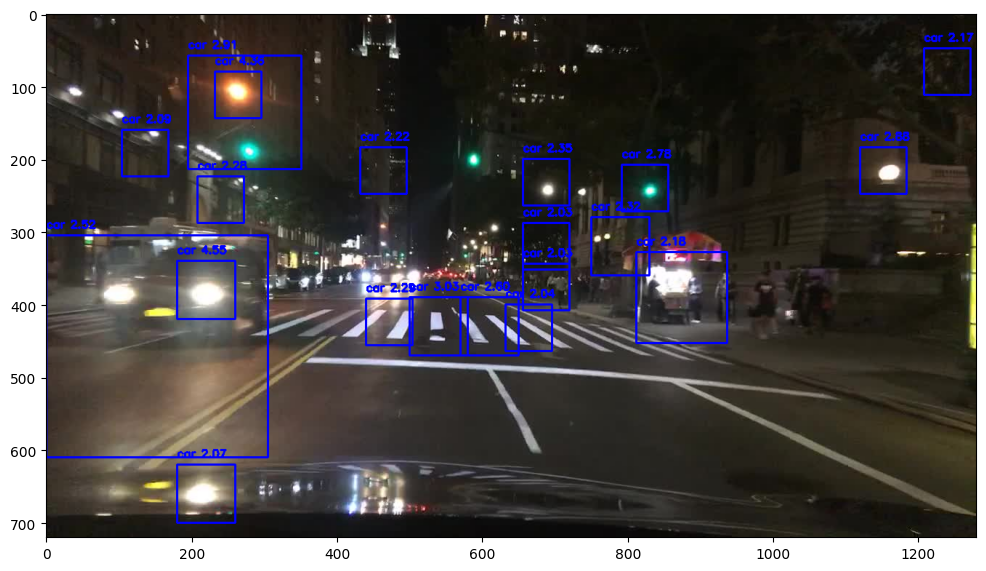

In [77]:
# Quick Debug Visualization
import cv2
import matplotlib.pyplot as plt

model = joblib.load(MODEL_PATH)

# Load one test image
# img_name = unique_images[0] # Get first image from your list
img_name = "000d35d3-41990aa4"
img_path = os.path.join(IMG_DIR, img_name if img_name.endswith('.jpg') else img_name+'.jpg')
img = cv2.imread(img_path)

# Run detection with a LOWER threshold
# We manually override the threshold inside detect_objects or just print raw scores
print(f"Debug: Visualizing {img_name}")
boxes, scores = detect_objects(model, img)

print(f"Found {len(boxes)} boxes.")
print(f"Top 5 Scores: {scores[:5]}") 

for box, score in zip(boxes, scores):
    x1, y1, x2, y2 = box
    # Draw Blue Box
    # print(f"car, {x1}, {y1}, {x2}, {y2}")
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(img, f"car {score:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()